# House Prices Kaggle Competition

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

The goal to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

Metric: Root-Mean-Squared-Error (RMSE)

I submitted online an answer to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Load Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go

from statsmodels.graphics.gofplots import qqplot

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.impute import KNNImputer

from sklearn.model_selection import cross_validate, learning_curve, train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import max_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel

from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error

from sklearn import set_config; set_config(display = "diagram")

from xgboost import XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import pickle
import dill as pickle

## Load Data

Load the train dataset in a DataFrame `data` and create your `X` and `y`.

In [2]:
data = pd.read_csv("data/train.csv")
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
X = data.drop(columns=['SalePrice','Id'])
y = data.SalePrice
X.shape

(1460, 79)

# 🐣 1. BASELINE

### Initial feature overview

79 features is too much to deal with for a first baseline pipeline! Checking their `dtype` first:

In [4]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

❓ Create a Series called `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total?

Analysing categorical features:

In [5]:
feat_categorical_nunique = X.select_dtypes(include=object).nunique()
len(feat_categorical_nunique)

43

If I use `OneHotEncode` all categorical features, the feature matrix would become pretty big with almost 300 (highly correlated) features for only 1400 observations. Ideally, the model should have 50-100 features max (Ref [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

Strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to the model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

<AxesSubplot:>

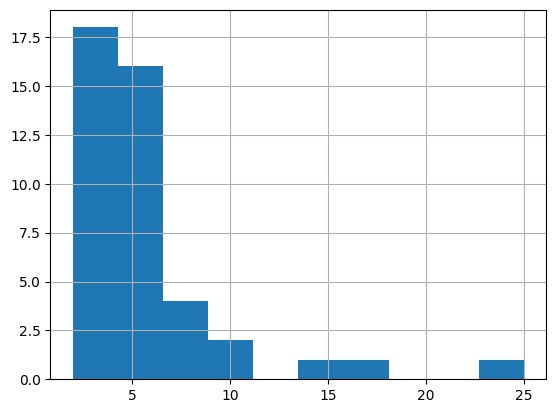

In [6]:
feat_categorical_nunique.hist()

As a start, I'm simply removing all features that have **7 unique values or more**, and one-hot-encode every others.

In [7]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique<7].index)
feat_categorical_small
len(feat_categorical_small)

34

## 1.2 Baseline Pipe

### Preprocessing pipeline

---
Categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


Numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 

In [8]:
#Categorical pipeline
pipe_cat = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                         OneHotEncoder(handle_unknown="ignore"))
# Numerical pipeline
pipe_num = make_pipeline(SimpleImputer(), MinMaxScaler())

In [9]:
preproc_baseline = make_column_transformer(
    (pipe_cat, feat_categorical_small),
    (pipe_num, make_column_selector(dtype_include=["int64", "float64"])))

In [10]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQua...
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...]),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa85cdfb6a0>)])

❓ Look at the **shape** of your preprocessed dataframe.

In [11]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 183)

## Model Baseline

In [12]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQu...
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa85cdfb6a0>)])),
                ('ridge', Ridge())])

### Add Estimator

Creating the scorer rmsle and a negative one rmsle_neg for the GridSearch to _maximize_

In [13]:
# This is the metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is the score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

### Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Which performance metric do you need? Is it readily available in Sklearn?

Sadly, it isn't! We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search. The process is described below:


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

5-fold cross_validate to get a first glance at the baseline perf.

In [14]:
#Evaluate metric(s) by cross-validation and also record fit/score times. Do not confuse with cross_val_score,
#which evaluates a score
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.1664290752086171

## Predict Baseline

Predict from the Kaggle `test.csv` dataset .

In [15]:
X_test = pd.read_csv("data/test.csv")
X_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [16]:
X_test_ids = X_test['Id'] # Keep ids for the submission
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([113256.76959388, 136811.0145436 , 174901.68834287, ...,
       157216.07718185, 111472.49591662, 234985.99120322])

In [17]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,113256.769594


# Improving Prediction

🎉 🎉 Congratulation on having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

Now, your goal is to improve your prediction and submit it to Kaggle **at least 30 minutes before the Recap ⏳**

We have some suggestions for improvements below: **pick your battles** and **incrementally** improve your pipeline as you see fit!


**Estimators**
- Linear Models: fine-tune regularization
- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking
- Stacking!
- XGBoost!

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- 🤷

## Preprocessing Iteration

## 2.1 Preprocessing Iteration ♲ 
**⚠️ Come back here only after you have iterated on your estimators in section 2.2 ⚠️**

⏩ Collapse me if I'm not in use!

### Ordinal Encoding (~1h)

❓ Look at the following feature. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that! Check it out below and make sure to understand how this works 👇

Split categorical preprocessor into:

- `preproc_ordinal` to ordinally encode **some features** of choice
- `preproc_nominal` to one hot encode the other ones

In [18]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** (of your choice)
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort your features alphabetically to avoid bad surprises
</details>

In [19]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

In [20]:
#Encode categorical features as an integer array. The input to this transformer should be an array-like of integers 
#or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal 
#integers. This results in a single column of integers (0 to n_categories - 1) per feature.

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically - get dict keys
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal] # get dict values
feat_ordinal_values_sorted

[['missing', 'Po', 'Fa', 'TA', 'Gd'],
 ['missing', 'No', 'Mn', 'Av', 'Gd'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Unf', 'RFn', 'Fin'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
 ['missing', 'Sev', 'Mod', 'Gtl'],
 ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
 ['missing', 'N', 'P', 'Y'],
 ['missing', 'Fa', 'Gd', 'Ex']]

In [21]:
#new pipeline
encoder_ordinal = OrdinalEncoder(categories=feat_ordinal_values_sorted, 
                                 dtype=np.int64, 
                                 handle_unknown='use_encoded_value', 
                                 unknown_value=-1) # Considers unknown values as worse than "missing"

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)
preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [22]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [23]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [24]:
preproc = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa85ce8f100>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categor...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [25]:
preproc.fit_transform(X).shape #still too much, go to statistical feature selection

(1460, 216)

### Target Engineering

Transforming target to log as we are asked to minimize the RMS**L**E.
- Check-out historgram of your target `y`. Normally distributed variables should be easier to predict with linear models. 
- Create `y_log` and new performance metrics

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

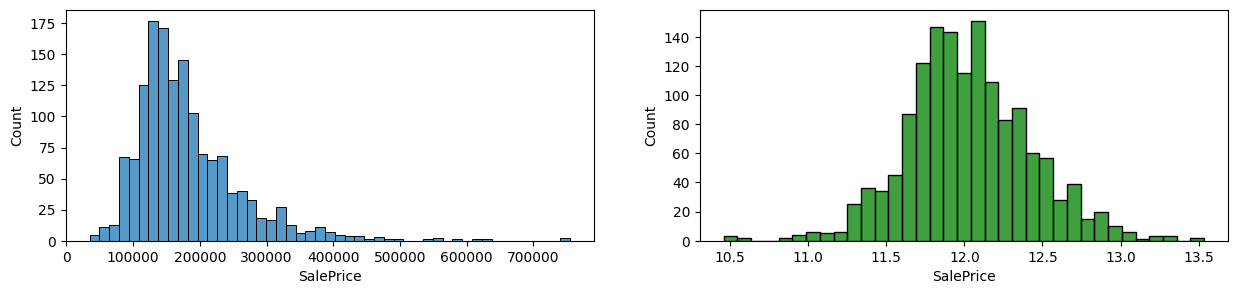

In [26]:
y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green')

In [27]:
#as our target is log, we don't need to use log metric anymore:
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### Statistical Feature Selection

The goal is to remove the least interesting features, to limit overfitting and shorten training time.

#### Univariate feature selection based on relationship with target `y`
- This will filter-out features that individually least explain the target

In [28]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 50% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa85ac36920>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7fa884d3e050>))])

In [29]:
preproc.fit_transform(X,y_log).shape #much better now

(1460, 108)

# Models Iteration

### Ridge Model

In [30]:
# #normal ridge
# model1 = Ridge()
# ridge_pipe = make_pipeline(preproc, model1)
# cross_val_score(ridge_pipe, X, y_log, cv=5, scoring=rmse).mean()

In [31]:
# # GridSearch the Ridge regularization
# param_grid =  {'ridge__alpha': np.linspace(0.5,2,num=20)}
# search_ridge = GridSearchCV(ridge_pipe, param_grid=param_grid, 
#                           cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

# search_ridge.fit(X, y_log);
# print(search_ridge.best_params_)
# search_ridge.best_score_

### KNN

In [32]:
# #normal KNN
# model2 = KNeighborsRegressor()
# KNN_pipe = make_pipeline(preproc, model2)
# cross_val_score(KNN_pipe, X, y_log, cv=5, scoring=rmse).mean()

In [33]:
# # GridSearch the KNN
# param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
# search_knn = GridSearchCV(KNN_pipe, param_grid=param_grid, 
#                           cv=3, n_jobs=-1, verbose=2, scoring=rmse_neg)

# search_knn.fit(X, y_log);
# print(search_knn.best_params_)
# search_knn.best_score_

### SVM

The free parameters in the model are C and epsilon

- Cfloat, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- epsilonfloat, default=0.1
Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [34]:
# #normal SVM linear kernel
# model31 = SVR(C=1, epsilon=0.05) #rbf is the standard
# SVM_pipe31 = make_pipeline(preproc, model31)
# cross_val_score(SVM_pipe31, X, y_log, cv=5, scoring=rmse).mean()

In [35]:
# #normal SVM linear kernel
# model32 = SVR(kernel='linear', C=1, epsilon=0.05)
# SVM_pipe32 = make_pipeline(preproc, model32)
# cross_val_score(SVM_pipe32, X, y_log, cv=5, scoring=rmse).mean()

In [36]:
# # GridSearch
# param_grid =  {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
#               'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
#                #'svr__coef0': [0.0, 0.1, 0.5,1],
#               }
# search_svm_rbf = GridSearchCV(SVM_pipe31, param_grid=param_grid, 
#                           cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

# search_svm_rbf.fit(X, y_log);
# svm_rbf_best = search_svm_rbf.best_estimator_
# print(search_svm_rbf.best_params_)
# search_svm_rbf.best_score_

### Decision Trees - NOT THE BEST

In [37]:
# #Esemble decision trees
# model4 = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
# trees_pipe = make_pipeline(preproc, model4)
# score = cross_val_score(trees_pipe, X, y_log, cv=5, scoring=rmse)
# print(score.std())
# score.mean()

### Random Forest - NOT THE BEST

In [38]:
# #Ensemble random forest
# model5 = RandomForestRegressor(max_depth=50, min_samples_leaf=20)
# forest_pipe = make_pipeline(preproc, model5)
# score = cross_val_score(forest_pipe, X, y_log, cv=5, scoring=rmse)
# print(score.std())
# score.mean()

### Boosting Trees

An AdaBoost [1] regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

The base estimator from which the boosted ensemble is built. If None, then the base estimator is DecisionTreeRegressor initialized with max_depth=3.

In [39]:
#Ensemble AdaBoost
model6 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
ada_pipe = make_pipeline(preproc, model6)
score = cross_val_score(ada_pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/pytho

0.008888863326514646


0.14059120625972293

In [40]:
#Ensemble Gradient
model7 = GradientBoostingRegressor() # n_estimators default=100
gradient_pipe = make_pipeline(preproc, model7)
score = cross_val_score(gradient_pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.009848417499712221


0.12543118917730006

# VOTING

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction.

In [41]:
#train best algorithms and agg the predictions

catboost = CatBoostRegressor()
xgboost = XGBRegressor()
gboost = GradientBoostingRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)
ridge = Ridge(alpha= 0.9736842105263157)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
SVM = SVR(C=1, epsilon=0.05)

model8 = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm", SVM),
                 ("cat", catboost),("XGB", xgboost)],
    weights = [1,1,1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

pipe_voting = make_pipeline(preproc, model8)
score = cross_val_score(pipe_voting, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/pytho

Learning rate set to 0.04196
0:	learn: 0.3934548	total: 490ms	remaining: 8m 9s
1:	learn: 0.3829027	total: 562ms	remaining: 4m 40s
2:	learn: 0.3724994	total: 616ms	remaining: 3m 24s
3:	learn: 0.3622764	total: 642ms	remaining: 2m 39s
4:	learn: 0.3531794	total: 722ms	remaining: 2m 23s
5:	learn: 0.3442858	total: 753ms	remaining: 2m 4s
6:	learn: 0.3349511	total: 791ms	remaining: 1m 52s
7:	learn: 0.3262930	total: 819ms	remaining: 1m 41s
8:	learn: 0.3183164	total: 894ms	remaining: 1m 38s
9:	learn: 0.3101973	total: 941ms	remaining: 1m 33s
10:	learn: 0.3036910	total: 997ms	remaining: 1m 29s
11:	learn: 0.2966983	total: 1.05s	remaining: 1m 26s
12:	learn: 0.2895516	total: 1.1s	remaining: 1m 23s
13:	learn: 0.2830686	total: 1.11s	remaining: 1m 18s
14:	learn: 0.2768776	total: 1.22s	remaining: 1m 20s
15:	learn: 0.2707169	total: 1.24s	remaining: 1m 15s
16:	learn: 0.2652645	total: 1.26s	remaining: 1m 12s
17:	learn: 0.2601275	total: 1.4s	remaining: 1m 16s
18:	learn: 0.2548429	total: 1.51s	remaining: 1m 1

0.1227908874718798

In [46]:
#train best algorithms and agg the predictions

catboost = CatBoostRegressor()
xgboost = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge(alpha= 0.9736842105263157)
SVM = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model9 = StackingRegressor(
    estimators=[("gboost", gboost),("adaboost", adaboost),("ridge", ridge), 
                ("svm", SVM), ("cat", catboost), ("XGB", xgboost)],
    
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model9)
score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


949:	learn: 0.0374222	total: 47.3s	remaining: 2.49s
950:	learn: 0.0373746	total: 47.3s	remaining: 2.44s
951:	learn: 0.0373267	total: 47.4s	remaining: 2.39s
952:	learn: 0.0373092	total: 47.4s	remaining: 2.34s
953:	learn: 0.0372974	total: 47.4s	remaining: 2.29s
954:	learn: 0.0372517	total: 47.4s	remaining: 2.23s
955:	learn: 0.0372128	total: 47.5s	remaining: 2.18s
956:	learn: 0.0371686	total: 47.5s	remaining: 2.13s
957:	learn: 0.0371338	total: 47.5s	remaining: 2.08s
958:	learn: 0.0371117	total: 47.5s	remaining: 2.03s
959:	learn: 0.0371007	total: 47.5s	remaining: 1.98s
960:	learn: 0.0370452	total: 47.5s	remaining: 1.93s
961:	learn: 0.0369692	total: 47.5s	remaining: 1.88s
962:	learn: 0.0369299	total: 47.5s	remaining: 1.82s
963:	learn: 0.0368903	total: 47.6s	remaining: 1.77s
964:	learn: 0.0368319	total: 47.6s	remaining: 1.73s
965:	learn: 0.0368298	total: 47.6s	remaining: 1.68s
966:	learn: 0.0367743	total: 47.7s	remaining: 1.63s
967:	learn: 0.0367321	total: 47.7s	remaining: 1.58s
968:	learn: 

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


900:	learn: 0.0386481	total: 28.3s	remaining: 3.11s
901:	learn: 0.0386170	total: 28.3s	remaining: 3.08s
902:	learn: 0.0385717	total: 28.4s	remaining: 3.05s
903:	learn: 0.0385445	total: 28.4s	remaining: 3.02s
904:	learn: 0.0385127	total: 28.5s	remaining: 2.99s
905:	learn: 0.0384554	total: 28.5s	remaining: 2.96s
906:	learn: 0.0384175	total: 28.5s	remaining: 2.92s
907:	learn: 0.0383649	total: 28.6s	remaining: 2.89s
908:	learn: 0.0383260	total: 28.6s	remaining: 2.86s
909:	learn: 0.0382586	total: 28.6s	remaining: 2.83s
910:	learn: 0.0382002	total: 28.6s	remaining: 2.79s
911:	learn: 0.0381595	total: 28.6s	remaining: 2.76s
912:	learn: 0.0381029	total: 28.7s	remaining: 2.73s
913:	learn: 0.0380375	total: 28.7s	remaining: 2.7s
914:	learn: 0.0379964	total: 28.7s	remaining: 2.67s
915:	learn: 0.0379314	total: 28.7s	remaining: 2.63s
916:	learn: 0.0378920	total: 28.8s	remaining: 2.6s
917:	learn: 0.0378595	total: 28.8s	remaining: 2.57s
918:	learn: 0.0378012	total: 28.8s	remaining: 2.54s
919:	learn: 0.

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/pytho

55:	learn: 0.1549374	total: 3.7s	remaining: 1m 2s
56:	learn: 0.1536828	total: 3.74s	remaining: 1m 1s
57:	learn: 0.1524902	total: 3.8s	remaining: 1m 1s
58:	learn: 0.1512111	total: 3.83s	remaining: 1m 1s
59:	learn: 0.1499657	total: 3.83s	remaining: 1m
60:	learn: 0.1488665	total: 3.84s	remaining: 59.1s
61:	learn: 0.1477169	total: 3.85s	remaining: 58.3s
62:	learn: 0.1466104	total: 3.92s	remaining: 58.3s
63:	learn: 0.1455436	total: 4.02s	remaining: 58.8s
64:	learn: 0.1444306	total: 4.12s	remaining: 59.3s
65:	learn: 0.1434388	total: 4.16s	remaining: 58.8s
66:	learn: 0.1424791	total: 4.3s	remaining: 60s
67:	learn: 0.1414874	total: 4.33s	remaining: 59.3s
68:	learn: 0.1405420	total: 4.44s	remaining: 59.9s
69:	learn: 0.1397055	total: 4.54s	remaining: 1m
70:	learn: 0.1388682	total: 4.6s	remaining: 1m
71:	learn: 0.1378955	total: 4.66s	remaining: 1m
72:	learn: 0.1369662	total: 4.67s	remaining: 59.4s
73:	learn: 0.1360076	total: 4.71s	remaining: 58.9s
74:	learn: 0.1352905	total: 4.75s	remaining: 58.6

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


215:	learn: 0.0931884	total: 12.6s	remaining: 45.6s
216:	learn: 0.0930085	total: 12.6s	remaining: 45.4s
217:	learn: 0.0928850	total: 12.6s	remaining: 45.3s
218:	learn: 0.0927564	total: 12.6s	remaining: 45s
219:	learn: 0.0925782	total: 12.7s	remaining: 45.1s
220:	learn: 0.0923535	total: 12.8s	remaining: 45s
221:	learn: 0.0922499	total: 12.9s	remaining: 45.2s
222:	learn: 0.0920936	total: 13s	remaining: 45.3s
223:	learn: 0.0920328	total: 13.1s	remaining: 45.3s
224:	learn: 0.0919312	total: 13.1s	remaining: 45.2s
225:	learn: 0.0918038	total: 13.2s	remaining: 45.2s
226:	learn: 0.0916842	total: 13.3s	remaining: 45.2s
227:	learn: 0.0916107	total: 13.3s	remaining: 45.1s
228:	learn: 0.0915107	total: 13.4s	remaining: 45s
229:	learn: 0.0914288	total: 13.4s	remaining: 45s
230:	learn: 0.0913512	total: 13.5s	remaining: 44.8s
231:	learn: 0.0912914	total: 13.5s	remaining: 44.7s
232:	learn: 0.0911502	total: 13.6s	remaining: 44.7s
233:	learn: 0.0909456	total: 13.6s	remaining: 44.5s
234:	learn: 0.0907867	

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


218:	learn: 0.0899349	total: 12s	remaining: 42.8s
219:	learn: 0.0896370	total: 12.1s	remaining: 42.8s
220:	learn: 0.0894206	total: 12.2s	remaining: 42.9s
221:	learn: 0.0893550	total: 12.3s	remaining: 43s
222:	learn: 0.0892605	total: 12.3s	remaining: 42.9s
223:	learn: 0.0890376	total: 12.3s	remaining: 42.7s
224:	learn: 0.0889265	total: 12.4s	remaining: 42.7s
225:	learn: 0.0886757	total: 12.4s	remaining: 42.5s
226:	learn: 0.0885801	total: 12.4s	remaining: 42.3s
227:	learn: 0.0884821	total: 12.5s	remaining: 42.2s
228:	learn: 0.0884032	total: 12.5s	remaining: 42s
229:	learn: 0.0881651	total: 12.5s	remaining: 41.8s
230:	learn: 0.0880791	total: 12.6s	remaining: 41.8s
231:	learn: 0.0878347	total: 12.6s	remaining: 41.6s
232:	learn: 0.0876805	total: 12.7s	remaining: 41.7s
233:	learn: 0.0874842	total: 12.7s	remaining: 41.5s
234:	learn: 0.0872581	total: 12.8s	remaining: 41.5s
235:	learn: 0.0870167	total: 12.8s	remaining: 41.4s
236:	learn: 0.0868663	total: 12.9s	remaining: 41.5s
237:	learn: 0.0867

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


215:	learn: 0.0888437	total: 12.6s	remaining: 45.7s
216:	learn: 0.0887782	total: 12.6s	remaining: 45.6s
217:	learn: 0.0884411	total: 12.7s	remaining: 45.5s
218:	learn: 0.0883598	total: 12.7s	remaining: 45.3s
219:	learn: 0.0882742	total: 12.7s	remaining: 45.2s
220:	learn: 0.0880007	total: 12.9s	remaining: 45.3s
221:	learn: 0.0879048	total: 13s	remaining: 45.4s
222:	learn: 0.0878347	total: 13s	remaining: 45.3s
223:	learn: 0.0877514	total: 13s	remaining: 45.1s
224:	learn: 0.0875698	total: 13s	remaining: 44.8s
225:	learn: 0.0874899	total: 13.2s	remaining: 45.1s
226:	learn: 0.0873040	total: 13.2s	remaining: 45s
227:	learn: 0.0869546	total: 13.3s	remaining: 45s
228:	learn: 0.0868350	total: 13.4s	remaining: 45s
229:	learn: 0.0867349	total: 13.5s	remaining: 45.1s
230:	learn: 0.0864980	total: 13.6s	remaining: 45.1s
231:	learn: 0.0864267	total: 13.6s	remaining: 45s
232:	learn: 0.0862881	total: 13.7s	remaining: 44.9s
233:	learn: 0.0862084	total: 13.7s	remaining: 44.7s
234:	learn: 0.0860060	total:

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


373:	learn: 0.0717126	total: 21s	remaining: 35.1s
374:	learn: 0.0715935	total: 21.1s	remaining: 35.2s
375:	learn: 0.0715498	total: 21.1s	remaining: 35.1s
376:	learn: 0.0714176	total: 21.2s	remaining: 35s
377:	learn: 0.0712843	total: 21.2s	remaining: 34.9s
378:	learn: 0.0711502	total: 21.3s	remaining: 34.8s
379:	learn: 0.0710322	total: 21.3s	remaining: 34.8s
380:	learn: 0.0709331	total: 21.3s	remaining: 34.7s
381:	learn: 0.0707619	total: 21.4s	remaining: 34.6s
382:	learn: 0.0705789	total: 21.4s	remaining: 34.5s
383:	learn: 0.0704753	total: 21.4s	remaining: 34.4s
384:	learn: 0.0703458	total: 21.5s	remaining: 34.3s
385:	learn: 0.0702116	total: 21.5s	remaining: 34.2s
386:	learn: 0.0700580	total: 21.5s	remaining: 34.1s
387:	learn: 0.0699053	total: 21.6s	remaining: 34.1s
388:	learn: 0.0697820	total: 21.6s	remaining: 34s
389:	learn: 0.0697241	total: 21.7s	remaining: 33.9s
390:	learn: 0.0696233	total: 21.8s	remaining: 33.9s
391:	learn: 0.0695424	total: 21.8s	remaining: 33.8s
392:	learn: 0.0693

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


376:	learn: 0.0674576	total: 21.2s	remaining: 35.1s
377:	learn: 0.0673335	total: 21.3s	remaining: 35s
378:	learn: 0.0673143	total: 21.3s	remaining: 34.9s
379:	learn: 0.0672149	total: 21.4s	remaining: 34.9s
380:	learn: 0.0670653	total: 21.4s	remaining: 34.7s
381:	learn: 0.0669503	total: 21.4s	remaining: 34.7s
382:	learn: 0.0668313	total: 21.4s	remaining: 34.5s
383:	learn: 0.0666720	total: 21.5s	remaining: 34.4s
384:	learn: 0.0665437	total: 21.6s	remaining: 34.5s
385:	learn: 0.0664947	total: 21.6s	remaining: 34.3s
386:	learn: 0.0662663	total: 21.6s	remaining: 34.2s
387:	learn: 0.0661268	total: 21.6s	remaining: 34.1s
388:	learn: 0.0659868	total: 21.7s	remaining: 34s
389:	learn: 0.0658184	total: 21.7s	remaining: 33.9s
390:	learn: 0.0656686	total: 21.7s	remaining: 33.8s
391:	learn: 0.0656585	total: 21.7s	remaining: 33.7s
392:	learn: 0.0655225	total: 21.8s	remaining: 33.6s
393:	learn: 0.0655056	total: 21.8s	remaining: 33.5s
394:	learn: 0.0653520	total: 21.8s	remaining: 33.4s
395:	learn: 0.06

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


317:	learn: 0.0785952	total: 18.7s	remaining: 40.1s
318:	learn: 0.0785730	total: 18.8s	remaining: 40.1s
319:	learn: 0.0785571	total: 18.8s	remaining: 40s
320:	learn: 0.0784944	total: 18.9s	remaining: 40s
321:	learn: 0.0784783	total: 19s	remaining: 39.9s
322:	learn: 0.0783254	total: 19.1s	remaining: 40s
323:	learn: 0.0783155	total: 19.1s	remaining: 39.9s
324:	learn: 0.0782053	total: 19.2s	remaining: 39.8s
325:	learn: 0.0781146	total: 19.3s	remaining: 39.8s
326:	learn: 0.0780988	total: 19.4s	remaining: 39.9s
327:	learn: 0.0780847	total: 19.5s	remaining: 39.9s
328:	learn: 0.0780066	total: 19.5s	remaining: 39.8s
329:	learn: 0.0779974	total: 19.6s	remaining: 39.8s
330:	learn: 0.0778884	total: 19.6s	remaining: 39.7s
331:	learn: 0.0777807	total: 19.7s	remaining: 39.6s
332:	learn: 0.0776458	total: 19.7s	remaining: 39.5s
333:	learn: 0.0774914	total: 19.8s	remaining: 39.5s
334:	learn: 0.0774735	total: 19.8s	remaining: 39.4s
335:	learn: 0.0773360	total: 19.9s	remaining: 39.4s
336:	learn: 0.077246

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


531:	learn: 0.0558480	total: 32.6s	remaining: 28.6s
532:	learn: 0.0557807	total: 32.6s	remaining: 28.6s
533:	learn: 0.0557133	total: 32.8s	remaining: 28.6s
534:	learn: 0.0556617	total: 32.8s	remaining: 28.5s
535:	learn: 0.0555533	total: 32.9s	remaining: 28.5s
536:	learn: 0.0554720	total: 33s	remaining: 28.5s
537:	learn: 0.0553921	total: 33.1s	remaining: 28.4s
538:	learn: 0.0553069	total: 33.2s	remaining: 28.4s
539:	learn: 0.0552055	total: 33.2s	remaining: 28.3s
540:	learn: 0.0550851	total: 33.3s	remaining: 28.2s
541:	learn: 0.0549700	total: 33.3s	remaining: 28.2s
542:	learn: 0.0548476	total: 33.4s	remaining: 28.1s
543:	learn: 0.0547732	total: 33.5s	remaining: 28.1s
544:	learn: 0.0546730	total: 33.5s	remaining: 28s
545:	learn: 0.0545819	total: 33.5s	remaining: 27.9s
546:	learn: 0.0544995	total: 33.6s	remaining: 27.8s
547:	learn: 0.0544132	total: 33.6s	remaining: 27.7s
548:	learn: 0.0543317	total: 33.6s	remaining: 27.6s
549:	learn: 0.0542332	total: 33.6s	remaining: 27.5s
550:	learn: 0.05

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


476:	learn: 0.0643632	total: 28.9s	remaining: 31.6s
477:	learn: 0.0642845	total: 28.9s	remaining: 31.6s
478:	learn: 0.0642482	total: 29s	remaining: 31.6s
479:	learn: 0.0641424	total: 29.2s	remaining: 31.6s
480:	learn: 0.0641087	total: 29.3s	remaining: 31.7s
481:	learn: 0.0640165	total: 29.4s	remaining: 31.6s
482:	learn: 0.0639486	total: 29.4s	remaining: 31.5s
483:	learn: 0.0638404	total: 29.5s	remaining: 31.5s
484:	learn: 0.0637731	total: 29.6s	remaining: 31.5s
485:	learn: 0.0637252	total: 29.7s	remaining: 31.4s
486:	learn: 0.0636340	total: 29.7s	remaining: 31.3s
487:	learn: 0.0635222	total: 29.8s	remaining: 31.2s
488:	learn: 0.0635138	total: 29.9s	remaining: 31.2s
489:	learn: 0.0634050	total: 30s	remaining: 31.2s
490:	learn: 0.0632869	total: 30.1s	remaining: 31.2s
491:	learn: 0.0632287	total: 30.1s	remaining: 31.1s
492:	learn: 0.0631972	total: 30.2s	remaining: 31s
493:	learn: 0.0630990	total: 30.3s	remaining: 31s
494:	learn: 0.0630181	total: 30.4s	remaining: 31s
495:	learn: 0.0629146	

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


4:	learn: 0.3471326	total: 222ms	remaining: 44.3s
5:	learn: 0.3387158	total: 259ms	remaining: 42.9s
6:	learn: 0.3307451	total: 273ms	remaining: 38.7s
7:	learn: 0.3227775	total: 291ms	remaining: 36s
8:	learn: 0.3161316	total: 312ms	remaining: 34.3s
9:	learn: 0.3090751	total: 356ms	remaining: 35.2s
10:	learn: 0.3014729	total: 378ms	remaining: 34s
11:	learn: 0.2948393	total: 417ms	remaining: 34.4s
12:	learn: 0.2885903	total: 443ms	remaining: 33.6s
13:	learn: 0.2820502	total: 454ms	remaining: 32s
14:	learn: 0.2765078	total: 472ms	remaining: 31s
15:	learn: 0.2709840	total: 499ms	remaining: 30.7s
16:	learn: 0.2652090	total: 513ms	remaining: 29.7s
17:	learn: 0.2597812	total: 548ms	remaining: 29.9s
18:	learn: 0.2549810	total: 612ms	remaining: 31.6s
19:	learn: 0.2505266	total: 641ms	remaining: 31.4s
20:	learn: 0.2454759	total: 658ms	remaining: 30.7s
21:	learn: 0.2412261	total: 669ms	remaining: 29.7s
22:	learn: 0.2367143	total: 710ms	remaining: 30.1s
23:	learn: 0.2326903	total: 733ms	remaining: 

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


167:	learn: 0.0944800	total: 7.65s	remaining: 37.9s
168:	learn: 0.0942984	total: 7.71s	remaining: 37.9s
169:	learn: 0.0941389	total: 7.72s	remaining: 37.7s
170:	learn: 0.0939522	total: 7.75s	remaining: 37.6s
171:	learn: 0.0938449	total: 7.83s	remaining: 37.7s
172:	learn: 0.0936762	total: 7.93s	remaining: 37.9s
173:	learn: 0.0934469	total: 8.01s	remaining: 38s
174:	learn: 0.0933359	total: 8.03s	remaining: 37.9s
175:	learn: 0.0932326	total: 8.07s	remaining: 37.8s
176:	learn: 0.0931516	total: 8.09s	remaining: 37.6s
177:	learn: 0.0927048	total: 8.09s	remaining: 37.4s
178:	learn: 0.0924261	total: 8.1s	remaining: 37.1s
179:	learn: 0.0922721	total: 8.11s	remaining: 36.9s
180:	learn: 0.0922055	total: 8.13s	remaining: 36.8s
181:	learn: 0.0920569	total: 8.16s	remaining: 36.7s
182:	learn: 0.0918993	total: 8.22s	remaining: 36.7s
183:	learn: 0.0917130	total: 8.24s	remaining: 36.5s
184:	learn: 0.0915413	total: 8.24s	remaining: 36.3s
185:	learn: 0.0913977	total: 8.3s	remaining: 36.3s
186:	learn: 0.09

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


267:	learn: 0.0838693	total: 12.1s	remaining: 33.1s
268:	learn: 0.0837655	total: 12.1s	remaining: 33s
269:	learn: 0.0835472	total: 12.2s	remaining: 32.9s
270:	learn: 0.0833421	total: 12.2s	remaining: 32.8s
271:	learn: 0.0831639	total: 12.2s	remaining: 32.8s
272:	learn: 0.0830640	total: 12.3s	remaining: 32.8s
273:	learn: 0.0830079	total: 12.4s	remaining: 32.7s
274:	learn: 0.0828969	total: 12.4s	remaining: 32.7s
275:	learn: 0.0828564	total: 12.4s	remaining: 32.6s
276:	learn: 0.0826690	total: 12.4s	remaining: 32.5s
277:	learn: 0.0824380	total: 12.5s	remaining: 32.5s
278:	learn: 0.0823451	total: 12.5s	remaining: 32.4s
279:	learn: 0.0821181	total: 12.6s	remaining: 32.3s
280:	learn: 0.0819996	total: 12.6s	remaining: 32.2s
281:	learn: 0.0819344	total: 12.6s	remaining: 32.2s
282:	learn: 0.0818665	total: 12.7s	remaining: 32.1s
283:	learn: 0.0817938	total: 12.7s	remaining: 32s
284:	learn: 0.0817411	total: 12.8s	remaining: 32.2s
285:	learn: 0.0815716	total: 12.8s	remaining: 32s
286:	learn: 0.0814

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


641:	learn: 0.0443552	total: 25.6s	remaining: 14.3s
642:	learn: 0.0442660	total: 25.6s	remaining: 14.2s
643:	learn: 0.0442370	total: 25.7s	remaining: 14.2s
644:	learn: 0.0441766	total: 25.7s	remaining: 14.2s
645:	learn: 0.0440913	total: 25.8s	remaining: 14.1s
646:	learn: 0.0440054	total: 25.8s	remaining: 14.1s
647:	learn: 0.0439413	total: 25.9s	remaining: 14s
648:	learn: 0.0438866	total: 25.9s	remaining: 14s
649:	learn: 0.0438464	total: 26s	remaining: 14s
650:	learn: 0.0437439	total: 26s	remaining: 13.9s
651:	learn: 0.0436350	total: 26.1s	remaining: 13.9s
652:	learn: 0.0435386	total: 26.1s	remaining: 13.9s
653:	learn: 0.0434838	total: 26.1s	remaining: 13.8s
654:	learn: 0.0434410	total: 26.2s	remaining: 13.8s
655:	learn: 0.0433914	total: 26.3s	remaining: 13.8s
656:	learn: 0.0433315	total: 26.3s	remaining: 13.7s
657:	learn: 0.0432363	total: 26.3s	remaining: 13.7s
658:	learn: 0.0431576	total: 26.4s	remaining: 13.7s
659:	learn: 0.0431165	total: 26.5s	remaining: 13.7s
660:	learn: 0.0430188	

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


742:	learn: 0.0442277	total: 31.6s	remaining: 10.9s
743:	learn: 0.0441993	total: 31.6s	remaining: 10.9s
744:	learn: 0.0441609	total: 31.7s	remaining: 10.8s
745:	learn: 0.0440784	total: 31.7s	remaining: 10.8s
746:	learn: 0.0440047	total: 31.8s	remaining: 10.8s
747:	learn: 0.0439745	total: 31.8s	remaining: 10.7s
748:	learn: 0.0439250	total: 31.8s	remaining: 10.7s
749:	learn: 0.0438678	total: 31.9s	remaining: 10.6s
750:	learn: 0.0437868	total: 31.9s	remaining: 10.6s
751:	learn: 0.0437327	total: 31.9s	remaining: 10.5s
752:	learn: 0.0436704	total: 32s	remaining: 10.5s
753:	learn: 0.0436672	total: 32s	remaining: 10.4s
754:	learn: 0.0436008	total: 32s	remaining: 10.4s
755:	learn: 0.0435396	total: 32.1s	remaining: 10.3s
756:	learn: 0.0435039	total: 32.1s	remaining: 10.3s
757:	learn: 0.0434828	total: 32.1s	remaining: 10.3s
758:	learn: 0.0434567	total: 32.2s	remaining: 10.2s
759:	learn: 0.0433805	total: 32.3s	remaining: 10.2s
760:	learn: 0.0433234	total: 32.4s	remaining: 10.2s
761:	learn: 0.0432

0.1206611210529807

# Final submission

As the Stacking model obtained the best score, this is the model I choose.

In [ ]:
# Predict y_pred_baseline
pipe_stacking.fit(X,y)
y_pred_final = pipe_stacking.predict(X_test)
y_pred_final

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.043466
0:	learn: 77267.1995399	total: 119ms	remaining: 1m 59s
1:	learn: 75117.8813121	total: 123ms	remaining: 1m 1s
2:	learn: 73062.9629436	total: 125ms	remaining: 41.7s
3:	learn: 71054.2725633	total: 133ms	remaining: 33s
4:	learn: 69085.7583500	total: 136ms	remaining: 27.1s
5:	learn: 67331.7195741	total: 139ms	remaining: 23.1s
6:	learn: 65649.0997055	total: 142ms	remaining: 20.1s
7:	learn: 63968.2109220	total: 145ms	remaining: 18s
8:	learn: 62321.2473715	total: 149ms	remaining: 16.4s
9:	learn: 60854.2777117	total: 152ms	remaining: 15.1s
10:	learn: 59463.8173395	total: 155ms	remaining: 14s
11:	learn: 58113.7149406	total: 159ms	remaining: 13.1s
12:	learn: 56743.5359409	total: 162ms	remaining: 12.3s
13:	learn: 55377.2227770	total: 165ms	remaining: 11.6s
14:	learn: 54149.1087289	total: 170ms	remaining: 11.2s
15:	learn: 52905.6931904	total: 175ms	remaining: 10.7s
16:	learn: 51717.8051763	total: 179ms	remaining: 10.3s
17:	learn: 50688.6243820	total: 186ms	remaining: 1

/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/joharlewagon/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966:	learn: 0.0277663	total: 35.1s	remaining: 1.2s
967:	learn: 0.0277381	total: 35.2s	remaining: 1.16s
968:	learn: 0.0277155	total: 35.2s	remaining: 1.13s
969:	learn: 0.0276673	total: 35.2s	remaining: 1.09s
970:	learn: 0.0276511	total: 35.2s	remaining: 1.05s
971:	learn: 0.0276200	total: 35.3s	remaining: 1.02s
972:	learn: 0.0275828	total: 35.3s	remaining: 980ms
973:	learn: 0.0275367	total: 35.4s	remaining: 944ms
974:	learn: 0.0274978	total: 35.4s	remaining: 907ms
975:	learn: 0.0274886	total: 35.4s	remaining: 870ms
976:	learn: 0.0274418	total: 35.4s	remaining: 833ms
977:	learn: 0.0273883	total: 35.4s	remaining: 796ms
978:	learn: 0.0273746	total: 35.4s	remaining: 759ms
979:	learn: 0.0273481	total: 35.4s	remaining: 722ms
980:	learn: 0.0273198	total: 35.4s	remaining: 686ms
981:	learn: 0.0272985	total: 35.4s	remaining: 650ms
982:	learn: 0.0272857	total: 35.5s	remaining: 613ms
983:	learn: 0.0272282	total: 35.5s	remaining: 577ms
984:	learn: 0.0271935	total: 35.5s	remaining: 541ms
985:	learn: 0

In [ ]:
results = pd.concat([X_test_ids, pd.Series(y_pred_final, name="SalePrice")], axis=1)
results.head(10)

In [ ]:
results.to_csv('submission_baseline.csv', header=True, index=False)